In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd '/gdrive/My Drive/cnn-mnist-jupyter/'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/cnn-mnist-jupyter


In [0]:
from matplotlib import pyplot as plt
import numpy as np
import pickle
import gzip

%matplotlib inline

# Weights matrix  and biases vector

In [3]:
sizes = [784, 100, 10]

num_layers = len(sizes)

biases = [np.random.randn(y, 1) for y in sizes[1:]]
weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]

print([w.shape for w in weights], 'and', [b.shape for b in biases])


def sigmoid(z):
    return 1.0/(1.0 + np.exp(-z))


def feedforward(a):
    for b, w in zip(biases, weights):
        a = sigmoid(np.dot(w, a) + b)
    return a

[(100, 784), (10, 100)] and [(100, 1), (10, 1)]


In [4]:
print([w.shape for w in weights], 'and', [b.shape for b in biases])

[(100, 784), (10, 100)] and [(100, 1), (10, 1)]


In [5]:
inv = np.zeros((784, 1))

res = feedforward(inv)
print(res.shape)

(10, 1)


In [6]:
print(np.array2string(res.reshape((-1,)), separator=', ', formatter={'float_kind': lambda x: f'{x:0.2f}'}))

[1.00, 1.00, 0.77, 0.17, 0.98, 1.00, 0.33, 0.00, 0.01, 1.00]


In [0]:
def load_data():
    with gzip.open('data/mnist.pkl.gz', 'rb') as f:
        train_data, valid_data, test_data = pickle.load(f, encoding='latin1')
    
    return train_data, valid_data, test_data


train_data, valid_data, test_data = load_data()

In [8]:
[t.shape for t in train_data]

[(50000, 784), (50000,)]

In [0]:
x_train, y_train = train_data
x_valid, y_valid = valid_data
x_test, y_test = test_data

In [10]:
y_train

array([5, 0, 4, ..., 8, 4, 8])

In [0]:
def to_categorical(x):
    num_categories = np.unique(x).shape[0]
    vector = np.eye(num_categories, dtype='uint8')[x]
    return vector.reshape((-1, 10, 1))

yy_train = to_categorical(y_train)
yy_valid = to_categorical(y_valid)
yy_test = to_categorical(y_test)

In [12]:
yy_train.shape

(50000, 10, 1)

In [13]:
print(yy_train[0], y_train[0])

[[0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]] 5


In [14]:
x_train.shape

(50000, 784)

In [0]:
xx_train = x_train.reshape((-1, 784, 1))
xx_valid = x_valid.reshape((-1, 784, 1))
xx_test = x_test.reshape((-1, 784, 1))

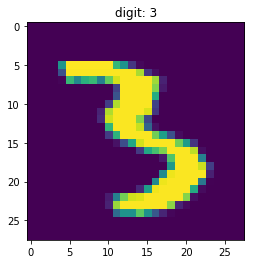

In [16]:
idx = np.random.randint(x_train.shape[0])
plt.imshow(x_train[idx].reshape((28, 28)))
plt.title(f'digit: {y_train[idx]}')
plt.show()

In [17]:
idx = np.random.randint(yy_train.shape[0])

print(yy_train[idx].transpose(), y_train[idx])

[[0 0 0 0 0 0 0 0 1 0]] 8


## SGD
Train the neural network using mini-batch stochastic gradient descent.  The `training_data` is a list of tuples
`(x, y)` representing the training inputs and the desired outputs.  The other non-optional parameters are self-explanatory.  If `test_data` is provided then the network will be evaluated against the test data after each epoch, and partial progress printed out.  This is useful for tracking progress, but slows things down substantially.

## update_mini_batch
Update the network's weights and biases by applying gradient descent using backpropagation to a single mini batch. The `mini_batch` is a list of tuples `(x, y)`, and `eta` is the learning rate.

## backdrop
Return a tuple `(nabla_b, nabla_w)` representing the gradient for the cost function C_x.  `nabla_b` and `nabla_w` are layer-by-layer lists of numpy arrays, similar to `self.biases` and `self.weights`.

In [0]:
def SGD(x, y, epochs, mini_batch_size, eta, test_data=None):
    training_data = np.array(list(zip(x, y)))
    n = training_data.shape[0]
    
    if test_data is not None:
        tx, ty = test_data
        n_test = tx.shape[0]
    
    for j in range(epochs):
        np.random.shuffle(training_data)
        
        mini_batches = [training_data[k:k+mini_batch_size] for k in range(0, n, mini_batch_size)]
        
        for mini_batch in mini_batches:
            update_mini_batch(mini_batch, eta)
            
        loss, acc, match, total = evaluate(x, y)
        print(f'Training dataset: {match} / {total},  loss: {loss:.7f},  accuracy: {acc:.2f}%')
            
        if test_data is not None:          
            loss, acc, match, total = evaluate(tx, ty)
            print(
                f'Epoch {j:02d}: test dataset {match} / {total} ', 
                f'test loss: {loss:.7f},  test accuracy: {acc:.2f}%'
            )
        else:
            print(f'Epoch {j:02d} complete')


def update_mini_batch(mini_batch, eta):
    global biases, weights
    
    nabla_b = [np.zeros(b.shape) for b in biases]
    nabla_w = [np.zeros(w.shape) for w in weights]

    for x, y in mini_batch:
        delta_nabla_b, delta_nabla_w = backprop(x, y)
        nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
        nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]

    n_batch = len(mini_batch)
    
    weights = [w-eta/n_batch*nw for w, nw in zip(weights, nabla_w)]
    biases  = [b-eta/n_batch*nb for b, nb in zip(biases,  nabla_b)]


def backprop(x, y):
    nabla_b = [np.zeros(b.shape) for b in biases]
    nabla_w = [np.zeros(w.shape) for w in weights]
    
    # feed forward
    activation = x
    
    activations = [x] # list to store all the activations, layer by layer
    zs = [] # list to store all the z vectors, layer by layer
    
    for b, w in zip(biases, weights):
        z = np.dot(w, activation) + b
        zs.append(z)
        activation = sigmoid(z)
        activations.append(activation)
        
    # backward pass
    
    # cost dericative
    delta = (activations[-1] - y) * sigmoid_prime(zs[-1])
    
    nabla_b[-1] = delta
    nabla_w[-1] = np.dot(delta, activations[-2].transpose())
    
    for l in range(2, num_layers):
        delta = np.dot(weights[-l+1].transpose(), delta) * sigmoid_prime(zs[-l])
        
        nabla_b[-l] = delta
        nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        
    return nabla_b, nabla_w
        

def sigmoid_prime(z):
    s = sigmoid(z)
    return s * (1 - s)


def evaluate(x, y):
    x = np.array([feedforward(l) for l in x])
    
    num_x = x.shape[0]
    
    loss = np.sum(np.linalg.norm(x-y)**2) / (2. * num_x)
    
    x = np.argmax(x, axis=1).reshape((-1,))
    y = np.argmax(y, axis=1).reshape((-1,))
    
    match = np.sum(np.int8(x == y))
    
    acc = match / num_x * 100

    return loss, acc, match, num_x

In [19]:
SGD(x=xx_train, y=yy_train, epochs=40, mini_batch_size=10, eta=3.0, test_data=(xx_test, yy_test))

Training dataset: 36202 / 50000,  loss: 0.1744866,  accuracy: 72.40%
Epoch 00: test dataset 7294 / 10000  test loss: 0.1733435,  test accuracy: 72.94%
Training dataset: 42020 / 50000,  loss: 0.1056560,  accuracy: 84.04%
Epoch 01: test dataset 8378 / 10000  test loss: 0.1085547,  test accuracy: 83.78%
Training dataset: 42682 / 50000,  loss: 0.0951941,  accuracy: 85.36%
Epoch 02: test dataset 8520 / 10000  test loss: 0.0996447,  test accuracy: 85.20%
Training dataset: 43011 / 50000,  loss: 0.0906334,  accuracy: 86.02%
Epoch 03: test dataset 8535 / 10000  test loss: 0.0965145,  test accuracy: 85.35%
Training dataset: 43307 / 50000,  loss: 0.0852025,  accuracy: 86.61%
Epoch 04: test dataset 8550 / 10000  test loss: 0.0942722,  test accuracy: 85.50%
Training dataset: 47691 / 50000,  loss: 0.0505029,  accuracy: 95.38%
Epoch 05: test dataset 9443 / 10000  test loss: 0.0584058,  test accuracy: 94.43%
Training dataset: 48255 / 50000,  loss: 0.0312834,  accuracy: 96.51%
Epoch 06: test dataset 95

In [20]:
loss, acc, match, total = evaluate(xx_valid, yy_valid)

print(f'validation dataset: {match} / {total},  loss: {loss:.5f},  accuracy: {acc:.2f}%')

validation dataset: 9672 / 10000,  loss: 0.03214,  accuracy: 96.72%


In [0]:
with gzip.open('dnn-weights-nb.pkl.gz', 'wb') as f:
    model_weights = (biases, weights)
    f.write(pickle.dumps(model_weights))